In [1]:
%load_ext autoreload 
%autoreload 2

In [1]:
import json
from privacypacking.utils.utils import load_logs, global_metrics
import pandas as pd
from experiments.ray.analysis import load_ray_experiment, load_latest_ray_experiment, load_latest_scheduling_results, load_latest_scheduling_results, load_latest_ray_experiment
import plotly.express as px
from privacypacking.budget.curves import  LaplaceCurve, GaussianCurve, SubsampledGaussianCurve
from privacypacking.budget import Budget, Task, Block
from privacypacking.schedulers.metrics import OverflowRelevance, FlatRelevance
from privacypacking.budget.block_selection import RandomBlocks
from privacypacking.utils.plot import plot_budgets
import yaml
from pathlib import Path
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
from experiments.ray.analysis import get_percentiles

In [5]:
# Budget totally unlocked from the beginning
# TODO: plot the delay. And before saving, add a line for Original DPF.
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_15-35-44"))

In [2]:
# rdf.iloc[0].config

In [20]:
# Older version with 100 mean tasks, no initial blocks, smaller profits.
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_15-35-44"))


# Unlocked, 500 mean tasks, running on C2 (mixed curves online.py)
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_03-35-42")) # incomplete (crashed)
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_13-46-19"))


px.line(
    rdf.query("T <= 10").sort_values("T"),
    x="T",
    y="realized_profit",
    color="scheduler_metric",
    # log_x=True,
    width=800,
    height=600,
    # range_y=[0,1_000],
    # range_y=[0,25_000],
    # title="Number of allocated tasks depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks</sup>"
)

In [14]:
# rdf.query("T ==1").explode("allocated_tasks_scheduling_delays")
rdf["T"].unique()

array([ 0.1 ,  6.  ,  4.  ,  1.  ,  2.  ,  0.5 ,  0.01, 10.  ,  8.  ])

In [21]:
delays = rdf.query("T ==1").explode("allocated_tasks_scheduling_delays")
dpf = rdf.query("T == 0.01 and scheduler_metric == 'DominantShares'").explode("allocated_tasks_scheduling_delays")
dpf["scheduler_metric"] = "Original DPF"
delays = pd.concat([delays, dpf]).sort_values(["T", "scheduler_metric"])

px.ecdf(
    delays,
    x="allocated_tasks_scheduling_delays",
    color="scheduler_metric",

)

In [25]:
delays.query("scheduler_metric == 'Fcfs'").allocated_tasks_scheduling_delays

39         1.0
39    0.998557
39    0.979756
39    0.962381
39    0.923482
        ...   
39    0.556171
39    0.550333
39    0.532439
39    0.458212
39    0.261206
Name: allocated_tasks_scheduling_delays, Length: 683, dtype: object

In [58]:
sq=delays.query(f"scheduler_metric == 'Original DPF'").allocated_tasks_scheduling_delays.value_counts()
series = sq.sort_index().cumsum()*1./len(sq)
indices = [0,100, 200, 300, 400, 500, 600]
d = pd.DataFrame(series).reset_index()
d["delay"] = d["index"]
d["fraction"] = d["allocated_tasks_scheduling_delays"]
d = d.drop(["index","allocated_tasks_scheduling_delays"], axis=1)
d

,delay,fraction
0,0.000041,0.001449
1,0.000042,0.002899
2,0.000088,0.004348
3,0.000114,0.005797
4,0.000118,0.007246
...,...,...
685,0.009962,0.994203
686,0.009967,0.995652
687,0.009978,0.997101
688,0.009986,0.998551


In [67]:
sq=delays.query(f"scheduler_metric == 'Original DPF'").allocated_tasks_scheduling_delays.value_counts()
series = sq.sort_index().cumsum()*1./len(sq)
indices = [0,100, 200, 300, 400, 500, 600, 689]
d = pd.DataFrame(series).reset_index()
# d = pd.DataFrame(series).iloc[indices].reset_index()
d["delay"] = d["index"]
d["fraction"] = d["allocated_tasks_scheduling_delays"]
d = d.drop(["index","allocated_tasks_scheduling_delays"], axis=1)
d = d.append({"delay": 5, "fraction": 1},ignore_index=True)
d["scheduler_metric"] = "Original DPF"
cdf = d

indices = [0,100, 200, 300, 400, 500, 600, -1]
for m in delays.scheduler_metric.unique():
    if m != "Original DPF":
        sq=delays.query(f"scheduler_metric == '{m}'").allocated_tasks_scheduling_delays.value_counts()
        series = sq.sort_index().cumsum()*1./len(sq)
        d = pd.DataFrame(series).reset_index()
        d["delay"] = d["index"]
        d["fraction"] = d["allocated_tasks_scheduling_delays"]
        d = d.drop(["index","allocated_tasks_scheduling_delays"], axis=1)
        d = d.append({"delay": 5, "fraction": 1},ignore_index=True)
        d["scheduler_metric"] = m
        cdf = pd.concat([cdf, d])
cdf


,delay,fraction,scheduler_metric
0,0.000041,0.001449,Original DPF
1,0.000042,0.002899,Original DPF
2,0.000088,0.004348,Original DPF
3,0.000114,0.005797,Original DPF
4,0.000118,0.007246,Original DPF
...,...,...,...
854,0.998557,0.996503,SoftKnapsack
855,0.999719,0.997669,SoftKnapsack
856,0.999797,0.998834,SoftKnapsack
857,1.000000,1.000000,SoftKnapsack


In [68]:
px.line(
    cdf,
    x="delay",
    y="fraction",
    color="scheduler_metric",
)

In [69]:
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "DynamicFlatRelevance": 1,
        "BatchOverflowRelevance":2,
        "SoftKnapsack":3,
        "Original DPF":4,
    }
    return d[row]

gnuplot_df = cdf.query("scheduler_metric not in ['Fcfs', 'FlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["delay", "fraction", "id", "scheduler_metric"]].sort_values(["id","delay"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_cdf_unlocked_T1.csv", index=False)

/tmp/ipykernel_3202223/2925347031.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [48]:
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_15-35-44"))
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_13-46-19"))

rdf.columns
rdf["avg_delay"] = rdf.allocated_tasks_scheduling_delays.apply(lambda x: np.mean(x))
rdf["p95"] = rdf.allocated_tasks_scheduling_delays.apply(lambda x: np.percentile(x, 95))

fig = px.line(
    rdf.sort_values(["T", "scheduler_metric"]).query("T <= 6"),
    x="T",
    y="avg_delay",
    color="scheduler_metric",
    log_x=True,
    width=1200,
    height=1000,
    # range_y=[0,15_000],
    title="10 + 20 blocks, privatekube, online. With and without profits.",
    facet_col="metric_recomputation_period",
    facet_row="data_path",
    facet_col_wrap=2,
)
fig

In [49]:
# TODO: copy and add original DPF, then dump to gnuplot. No need actually?
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "DynamicFlatRelevance": 1,
        "BatchOverflowRelevance":2,
        "SoftKnapsack":3

    }
    return d[row]

gnuplot_df = rdf.query("T <= 10 and scheduler_metric not in ['Fcfs', 'FlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["T", "avg_delay", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_online_batched_mixed_curves_N_without_profits_unlocked.csv", index=False)

In [26]:
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "FlatRelevance": 1,
        "VectorizedBatchOverflowRelevance":2
    }
    return d[row]

gnuplot_df = rdf.query("T <= 10 and scheduler_metric not in ['Fcfs', 'DynamicFlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["T", "n_allocated_tasks", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/online_batched_mixed_curves_N_without_profits_unlocked.csv", index=False)

/tmp/ipykernel_3782884/1428602290.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [7]:
gnuplot_df = rdf.query("T <= 10 and scheduler_metric != 'Fcfs'")

In [8]:
def map_metric_to_id(m):
    d = {
        "DominantShares": 0,
        "FlatRelevance": 1,
        "VectorizedBatchOverflowRelevance":2
    }
    return d[m]

In [9]:
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)

KeyError: 'DynamicFlatRelevance'

In [ ]:
gnuplot_df = gnuplot_df[["T", "n_allocated_tasks", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])

In [ ]:
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/online_batched_mixed_curves_N_without_profits_unlocked.csv", index=False)

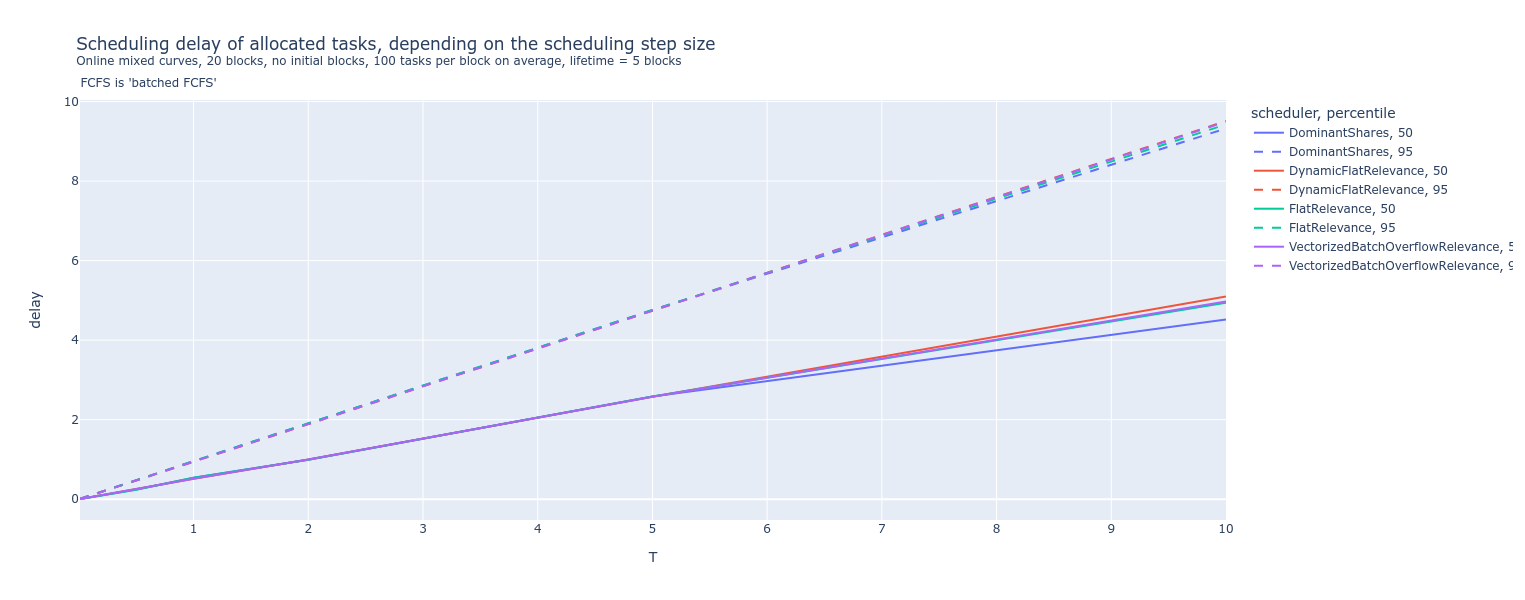

In [10]:
px.line(
    percentile_df.query("T <= 10 and scheduler != 'Fcfs'"),
    x="T",
    y="delay",
    color="scheduler",
    line_dash="percentile",
    width=800,
    height=600,
    line_dash_map={50:"solid",25:"dash",99:"dash", 95:"dash"},
    title="Scheduling delay of allocated tasks, depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks<br> FCFS is 'batched FCFS'</sup>"
)

In [12]:
def map_metric_to_id(row):
    d = {
        ("VectorizedBatchOverflowRelevance", 95):0,
        ("FlatRelevance", 95): 1,
        ("DominantShares", 95): 2,
        ("VectorizedBatchOverflowRelevance", 50):3,
        ("FlatRelevance", 50): 4,
        ("DominantShares", 50): 5,
    }
    return d[(row.scheduler, row.percentile)]

gnuplot_df = percentile_df.query("T <= 10 and scheduler not in ['Fcfs', 'DynamicFlatRelevance']")
gnuplot_df["id"] = gnuplot_df.apply(map_metric_to_id, axis=1)
gnuplot_df = gnuplot_df[["T", "delay", "id", "scheduler", "percentile"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_online_batched_mixed_curves_N_without_profits_unlocked.csv", index=False)

/tmp/ipykernel_3782884/3426873918.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [70]:
# Gradual unlocking
# Old version
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_18-51-49"))
# Running on C2 at 22:41

# Initial blocks, profits and 500 mean tasks
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_03-39-52")) # incomplete
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_13-47-44"))
# Just not so great in the end. What is the point of unlocking in this case?
px.line(
    rdf.sort_values("T"),
    x="T",
    y="realized_profit",
    color="scheduler_metric",
    # log_x=True,
    width=800,
    height=600,
    range_x=[0.1, 10],
    range_y=[0,1_000],
    # range_y=[0,25_000],
    # title="Number of allocated tasks depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks</sup>"
)

In [71]:
delays = rdf.query("T ==1").explode("allocated_tasks_scheduling_delays")
dpf = rdf.query("T == 0.01 and scheduler_metric == 'DominantShares'").explode("allocated_tasks_scheduling_delays")
dpf["scheduler_metric"] = "Original DPF"
delays = pd.concat([delays, dpf]).sort_values(["T", "scheduler_metric"])

px.ecdf(
    delays,
    x="allocated_tasks_scheduling_delays",
    color="scheduler_metric",

)

In [72]:
sq=delays.query(f"scheduler_metric == 'Original DPF'").allocated_tasks_scheduling_delays.value_counts()
series = sq.sort_index().cumsum()*1./len(sq)
indices = [0,100, 200, 300, 400, 500, 600, 689]
d = pd.DataFrame(series).reset_index()
# d = pd.DataFrame(series).iloc[indices].reset_index()
d["delay"] = d["index"]
d["fraction"] = d["allocated_tasks_scheduling_delays"]
d = d.drop(["index","allocated_tasks_scheduling_delays"], axis=1)
d = d.append({"delay": 5, "fraction": 1},ignore_index=True)
d["scheduler_metric"] = "Original DPF"
cdf = d

indices = [0,100, 200, 300, 400, 500, 600, -1]
for m in delays.scheduler_metric.unique():
    if m != "Original DPF":
        sq=delays.query(f"scheduler_metric == '{m}'").allocated_tasks_scheduling_delays.value_counts()
        series = sq.sort_index().cumsum()*1./len(sq)
        d = pd.DataFrame(series).reset_index()
        d["delay"] = d["index"]
        d["fraction"] = d["allocated_tasks_scheduling_delays"]
        d = d.drop(["index","allocated_tasks_scheduling_delays"], axis=1)
        d = d.append({"delay": 5, "fraction": 1},ignore_index=True)
        d["scheduler_metric"] = m
        cdf = pd.concat([cdf, d])
cdf

,delay,fraction,scheduler_metric
0,0.000042,0.001105,Original DPF
1,0.000088,0.002210,Original DPF
2,0.000118,0.003315,Original DPF
3,0.000150,0.004420,Original DPF
4,0.000206,0.005525,Original DPF
...,...,...,...
916,4.920308,0.996739,SoftKnapsack
917,4.953656,0.997826,SoftKnapsack
918,4.964170,0.998913,SoftKnapsack
919,4.975079,1.000000,SoftKnapsack


In [73]:
px.line(
    cdf,
    x="delay",
    y="fraction",
    color="scheduler_metric",
)

In [74]:
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "DynamicFlatRelevance": 1,
        "BatchOverflowRelevance":2,
        "SoftKnapsack":3,
        "Original DPF":4,
    }
    return d[row]

gnuplot_df = cdf.query("scheduler_metric not in ['Fcfs', 'FlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["delay", "fraction", "id", "scheduler_metric"]].sort_values(["id","delay"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_cdf_locked_T1.csv", index=False)

/tmp/ipykernel_3202223/3332678986.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [54]:
# TODO: copy and add original DPF, then dump to gnuplot. No need actually?
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "DynamicFlatRelevance": 1,
        "BatchOverflowRelevance":2,
        "SoftKnapsack":3

    }
    return d[row]

gnuplot_df = rdf.query("T <= 10 and scheduler_metric not in ['Fcfs', 'FlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["T", "n_allocated_tasks", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/online_batched_mixed_curves_N_without_profits_locked.csv", index=False)

In [19]:
# Gradual unlocking.
# Diff seed (1)
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_20-55-13"))
px.line(
    rdf.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    # log_x=True,
    width=800,
    height=600,
    range_y=[0,1000],
    title="Number of allocated tasks depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks</sup>"
)

In [51]:
# Delay
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_18-51-49"))


# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_20-55-13"))
# rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-10_13-46-19"))

rdf.columns
rdf["avg_delay"] = rdf.allocated_tasks_scheduling_delays.apply(lambda x: np.mean(x))
rdf["p95"] = rdf.allocated_tasks_scheduling_delays.apply(lambda x: np.percentile(x, 95))

fig = px.line(
    rdf.sort_values(["T", "scheduler_metric"]),
    x="T",
    y="avg_delay",
    color="scheduler_metric",
    # log_x=True,
    width=1200,
    height=1000,
    # range_y=[0,15_000],
    title="10 + 20 blocks, privatekube, online. With and without profits.",
    facet_col="metric_recomputation_period",
    facet_row="data_path",
    facet_col_wrap=2,
)
fig

In [52]:
# TODO: copy and add original DPF, then dump to gnuplot. No need actually?
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "DynamicFlatRelevance": 1,
        "BatchOverflowRelevance":2,
        "SoftKnapsack":3

    }
    return d[row]

gnuplot_df = rdf.query("T <= 10 and scheduler_metric not in ['Fcfs', 'FlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["T", "avg_delay", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_online_batched_mixed_curves_N_without_profits_locked.csv", index=False)

In [20]:
# Gradual unlocking.
# Diff seed (1) and 10 initial blocks.
rdf = load_ray_experiment(Path("/home/pierre/privacypacking/logs/ray/run_and_report_2021-12-09_20-55-13"))
px.line(
    rdf.sort_values("T"),
    x="T",
    y="n_allocated_tasks",
    color="scheduler_metric",
    # log_x=True,
    width=800,
    height=600,
    range_y=[0,1000],
    title="Number of allocated tasks depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks</sup>"
)

In [22]:
def map_metric_to_id(row):
    d = {
        "DominantShares": 0,
        "FlatRelevance": 1,
        "VectorizedBatchOverflowRelevance":2
    }
    return d[row]

gnuplot_df = rdf.query("T <= 10 and scheduler_metric not in ['Fcfs', 'DynamicFlatRelevance']")
gnuplot_df["id"] = gnuplot_df.scheduler_metric.apply(map_metric_to_id)
gnuplot_df = gnuplot_df[["T", "n_allocated_tasks", "id", "n_tasks", "scheduler", "scheduler_metric"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/online_batched_mixed_curves_N_without_profits_locked.csv", index=False)

/tmp/ipykernel_3782884/2971739988.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



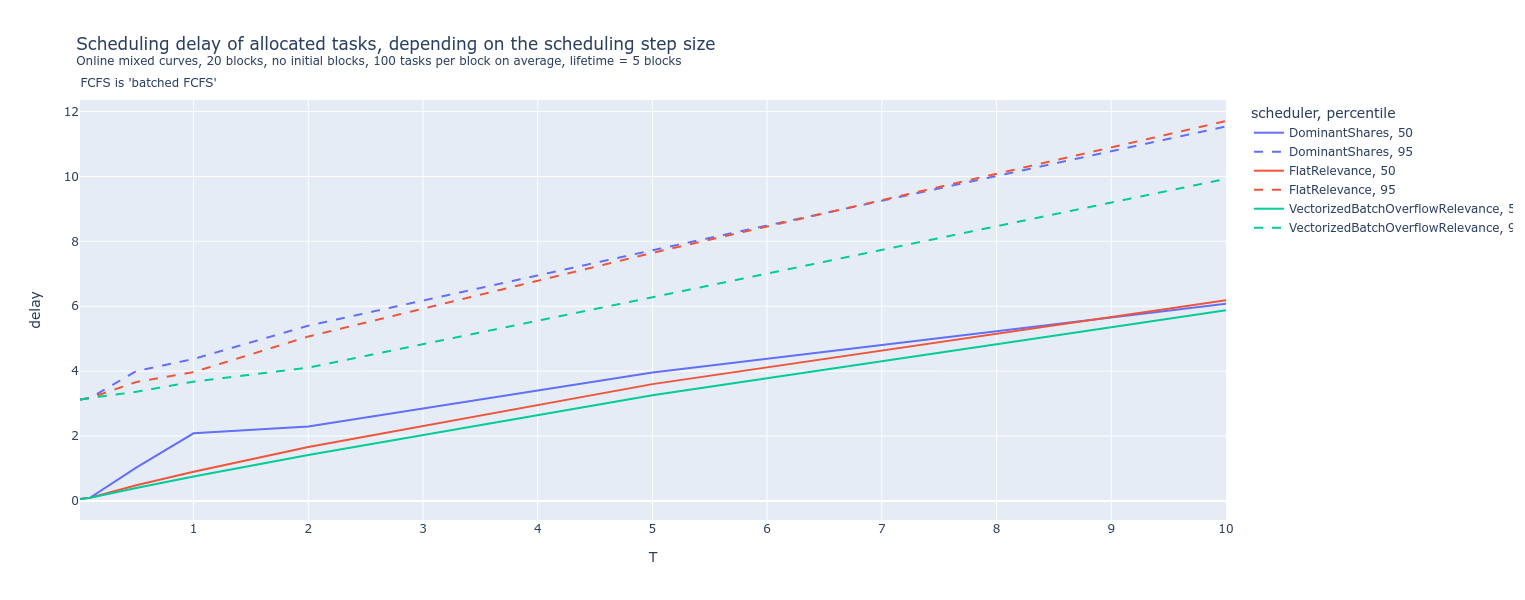

In [20]:
px.line(
    percentile_df.query("T <= 10 and scheduler != 'Fcfs'"),
    x="T",
    y="delay",
    color="scheduler",
    line_dash="percentile",
    width=800,
    height=600,
    line_dash_map={50:"solid",25:"dash",99:"dash", 95:"dash"},
    title="Scheduling delay of allocated tasks, depending on the scheduling step size<br><sup>Online mixed curves, 20 blocks, no initial blocks, 100 tasks per block on average, lifetime = 5 blocks<br> FCFS is 'batched FCFS'</sup>"
)

In [23]:
def map_metric_to_id(row):
    d = {
        ("VectorizedBatchOverflowRelevance", 95):0,
        ("FlatRelevance", 95): 1,
        ("DominantShares", 95): 2,
        ("VectorizedBatchOverflowRelevance", 50):3,
        ("FlatRelevance", 50): 4,
        ("DominantShares", 50): 5,
    }
    return d[(row.scheduler, row.percentile)]

gnuplot_df = percentile_df.query("T <= 10 and scheduler not in ['Fcfs', 'DynamicFlatRelevance']")
gnuplot_df["id"] = gnuplot_df.apply(map_metric_to_id, axis=1)
gnuplot_df = gnuplot_df[["T", "delay", "id", "scheduler", "percentile"]].sort_values(["id","T"])
gnuplot_df.to_csv("/home/pierre/privacypacking-paper/results/online_batched_mixed_curves/delay_online_batched_mixed_curves_N_without_profits_locked.csv", index=False)

/tmp/ipykernel_3782884/2767224933.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

